In [1]:
import pandas as pd

In [2]:
from pathlib import Path

In [3]:
data_dir = Path(f"cluster-test-data-2020-10-13/")
dfs = [
    pd.read_csv(f)
    for f in data_dir.glob("*.csv")
]
len(dfs)

5

In [4]:
cols = ["test_acc", "model_updates"]
dfs[0][cols].tail()

,test_acc,model_updates
2197,0.758281,1546233
2198,0.758336,1547015
2199,0.758504,1547797
2200,0.758496,1548579
2201,0.758399,1549361


In [5]:
[df.name.iloc[-1] for df in dfs]

['asgd', 'pada', 'padalr', 'hsgd', 'gd']

In [6]:
df = pd.concat(dfs)

In [7]:
df.columns

Index(['Unnamed: 0', 'partial_fit_calls', 'test_acc', 'test_loss', 'train_acc',
       'train_loss', 'train_eg', 'test_eg', 'max_iter', 'damper_name',
       'device', 'lr', 'max_batch_size', 'momentum', 'name', 'opt', 'scoring',
       'seed', 'weight_decay', 'model_updates', 'num_examples', 'len_dataset',
       'epochs', 'ident', 'acc', 'loss', 'damping', 'batch_size', 'lr_',
       'batch_growth_rate', 'dwell', 'initial_batch_size', 'pada_damping',
       'static_batch_size'],
      dtype='object')

(0.67, 0.77)

(0.9, 3159804.7735127327)

(0.9, 3159804.7735127327)

(0.67, 0.77)

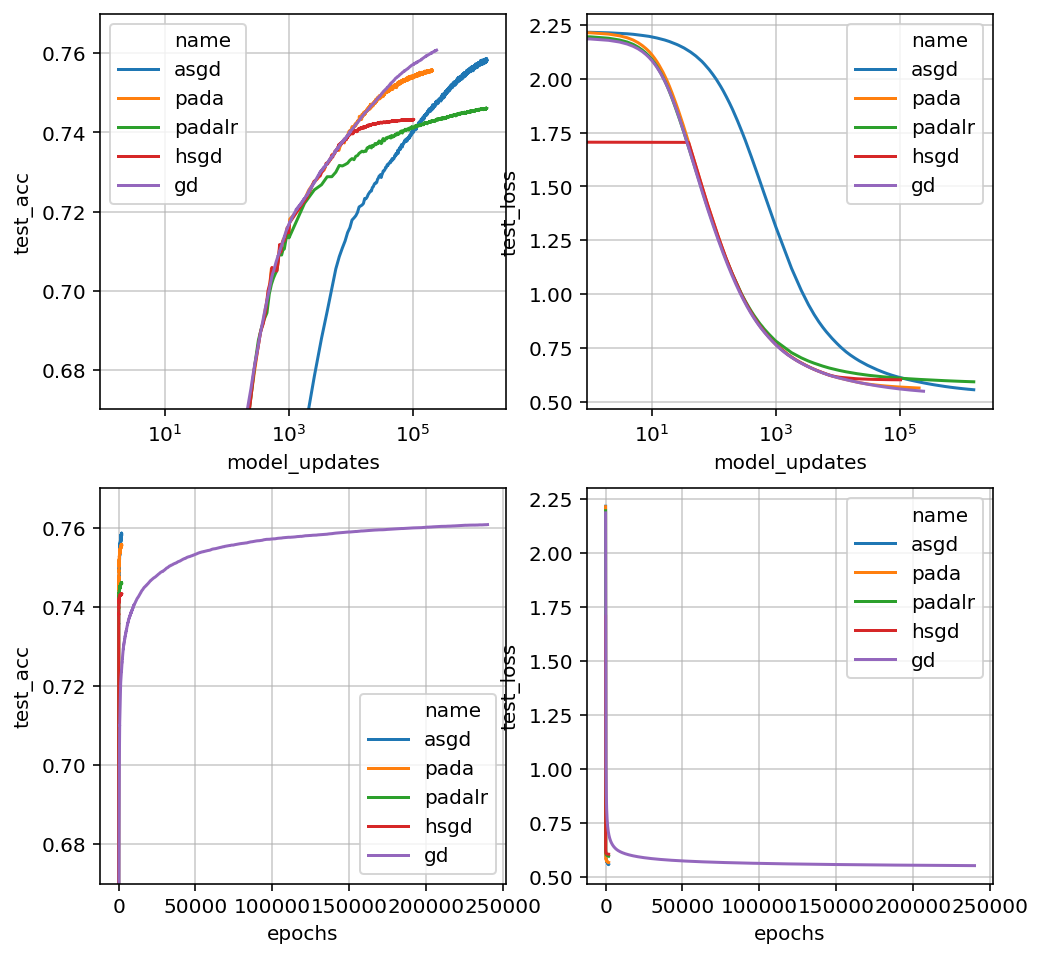

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 4
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2 * w, 2 * w))

for i, x in enumerate(["model_updates", "epochs"]):
    for j, y in enumerate(["test_acc", "test_loss"]):
#     for j, y in enumerate(["train_acc", "train_loss"]):
        ax = sns.lineplot(
            x=x,
            y=y,
            hue="name",
            data=df,
            ax=axs[i][j],
        )
        ax.grid(alpha=0.65)
        if "acc" in y:
            ax.set_ylim(0.67, 0.77)
            
#         elif "loss" in y:
#             ax.set_ylim(0.7, 1)
        if "updates" in x:
            ax.set_xscale("log", basex=10)
            ax.set_xlim(0.9, None)
        # ax.set_ylim(0.7, 1)

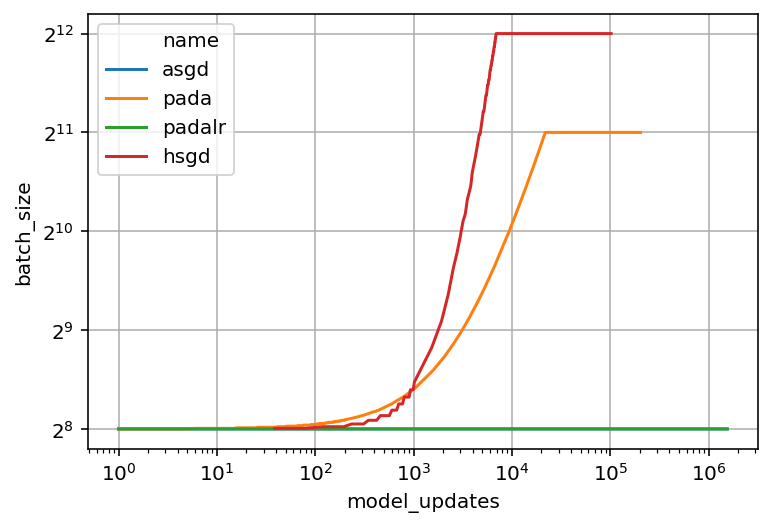

In [9]:
import seaborn as sns
ax = sns.lineplot(
    x="model_updates",
    y="batch_size",
    hue="name",
    data=df[df.name != "gd"],
)
ax.set_yscale("log", basey=2)
ax.set_xscale("log")
ax.grid()

In [10]:
show = df.copy()
show["damper_name_show"] = show["damper_name"]

show.loc[show.name == "pada", "damper_name_show"] = "PadaDamp"
show.loc[show.name == "padalr", "damper_name_show"] = "SGD"
show.loc[show.name == "gd", "damper_name_show"] = "GD"
show.loc[show.name == "asgd", "damper_name_show"] = "ASGD"
# n = 

In [12]:
import numpy as np

DAMPERS = ["pada", "padalr", "asgd", "gd", "hsgd"]
# DAMPERS = ["pada", "padalr", "asgd", "gd"]
COLORS = ["C0", "C3", "C1", "C2", "C5"]
LABELS = {"pada": "PadaDamp", "padalr": "SGD", "asgd": "ASGD", "gd": "GD", "hsgd": "HSGD"}
STYLES = ["-", "-.", "--", (0, (1, 1)), ":"]
WIDTHS = [2, 2, 2, 3, 2]

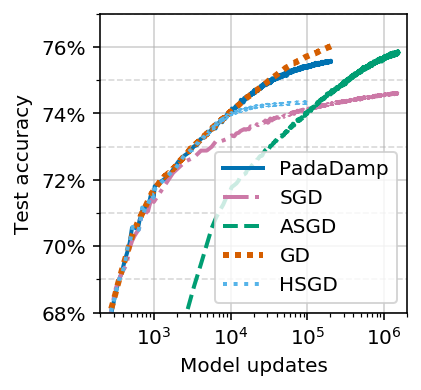

In [13]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-colorblind")

def lineplot(
    df,
    x,
    y,
    labels=None,
    hue_order=None,
    hues=None,
    styles=None,
    w=3,
    fig_ax=None,
    widths=None,
):
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(w, w))
    else:
        fig, ax = fig_ax
    if hue_order is None:
        hue_order = sorted(df.name.unique())
    if labels is None:
        labels = {}
    if widths is None:
        widths = [1] * len(hue_order)
    for k, d in enumerate(hue_order):
        label = labels.get(d, d)
        s = df[df.name == d]
        if not len(s):
            continue
        ax = s.plot(
            x=x,
            y=y,
            style=hues[k],
            linestyle=styles[k],
            ax=ax,
            label=label,
            linewidth=widths[k],
        )
    return fig, ax

x = "model_updates"
y = "test_acc"

w = 2.75
kwargs = dict(hues=COLORS, hue_order=DAMPERS, styles=STYLES, labels=LABELS, w=w, widths=WIDTHS)
fig, ax = lineplot(show, x, y, **kwargs)
ylim = (0.68, 0.77)
ax.set_ylim(*ylim)
ax.grid(alpha=0.6)
ax.set_ylabel("Test accuracy")
ax.set_xlabel("Model updates")
ax.set_xlim(0.2e3, 2e6)
ax.set_xscale("log", basex=10)
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v):,}" if v > 0 else "0"))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v / 1e3)}e3" if v > 0 else "0"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v * 100)}%"))
odd_percs = np.arange(50) * 2 + 1
ax.yaxis.set_minor_locator(plt.FixedLocator(odd_percs / 100))
ax.grid(alpha=0.5, which="minor", axis="y", linestyle="--")
fig.savefig("figs/padadamp-mu.pdf", bbox_inches="tight")


In [14]:
acc = 0.740
print(acc)
out = []
for name in df.name.unique():
    s = df[(df.name == name) & (df.test_acc >= acc)]
    print(name, len(s))
    idx = np.abs(s.test_acc - acc).idxmin()
    mu = s.loc[idx, "model_updates"]
    epochs = s.loc[idx, "epochs"]
    test_acc = s.loc[idx, "test_acc"]
    out.append({"name": name, "epochs": epochs, "test_acc": test_acc, "model_updates": mu, "acc": acc})
out

0.74
asgd 1857
pada 1948
padalr 1901
hsgd 1862
gd 2761


[{'name': 'asgd',
  'epochs': 125.40032,
  'test_acc': 0.7400239362539762,
  'model_updates': 97969,
  'acc': 0.74},
 {'name': 'pada',
  'epochs': 31.590629999999997,
  'test_acc': 0.7401919099660903,
  'model_updates': 9679,
  'acc': 0.74},
 {'name': 'padalr',
  'epochs': 85.36192,
  'test_acc': 0.7401105476992851,
  'model_updates': 66689,
  'acc': 0.74},
 {'name': 'hsgd',
  'epochs': 122.062785,
  'test_acc': 0.7400265608432282,
  'model_updates': 10287,
  'acc': 0.74},
 {'name': 'gd',
  'epochs': 9538.0,
  'test_acc': 0.7400003149507102,
  'model_updates': 9538,
  'acc': 0.74}]

In [15]:
s = show[show.name == "gd"]
idx = np.abs(s.test_acc - 0.75).idxmin()
s.loc[idx, "epochs"]

32100.0

In [16]:
o = pd.DataFrame(out)
o = o[["name", "epochs", "model_updates"]]
o = o.sort_values(by="epochs")
o

,name,epochs,model_updates
1,pada,31.590630,9679
2,padalr,85.361920,66689
3,hsgd,122.062785,10287
0,asgd,125.400320,97969
4,gd,9538.000000,9538


In [17]:
print(o.to_latex())

\begin{tabular}{llrr}
\toprule
{} &    name &       epochs &  model\_updates \\
\midrule
1 &    pada &    31.590630 &           9679 \\
2 &  padalr &    85.361920 &          66689 \\
3 &    hsgd &   122.062785 &          10287 \\
0 &    asgd &   125.400320 &          97969 \\
4 &      gd &  9538.000000 &           9538 \\
\bottomrule
\end{tabular}



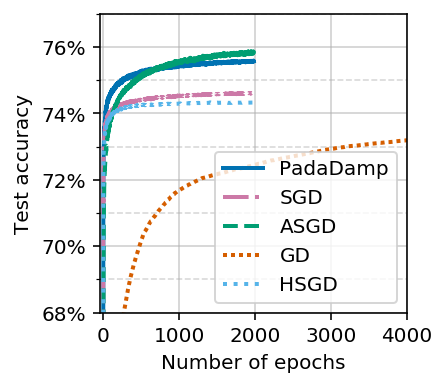

In [19]:
show["epochs"] = show["num_examples"] / show["len_dataset"]
x = "epochs"
y = "test_acc"

kwargs["widths"] = [np.median(kwargs["widths"])] * len(kwargs["widths"])

show["num_examples_show"] = show["num_examples"] / 1e6
fig, ax = lineplot(show, x, y, **kwargs)

ax.set_ylim(*ylim)
ax.grid(alpha=0.6)
ax.set_ylabel("Test accuracy")
# ax.set_xlabel("Number of epochs")
ax.set_xlabel("Number of epochs")
ax.set_xlim(-40.5, 4e3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v * 100)}%"))
# ax.xaxis.set_major_locator(plt.MultipleLocator(500))

odd_percs = np.arange(50) * 2 + 1
ax.yaxis.set_minor_locator(plt.FixedLocator(odd_percs / 100))
ax.grid(alpha=0.5, which="minor", linestyle="--")

fig.savefig("figs/padadamp-epochs.pdf", bbox_inches="tight")


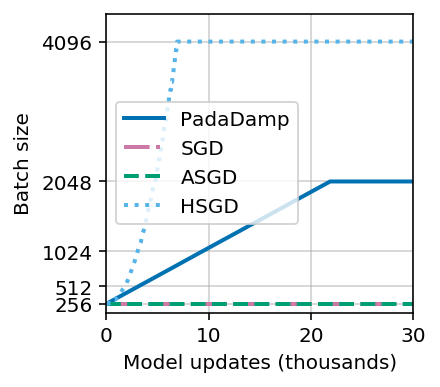

In [20]:
import numpy as np
x = "model_updates_show"
y = "batch_size"

show["model_updates_show"] = show["model_updates"] / 1e3
fig, ax = plt.subplots(figsize=(w, w))

fig, ax = lineplot(
    show[show.name != "gd"],
    x,
    y,
    **kwargs,
    fig_ax=(fig, ax),
)
# ax.set_ylim(0.68, 0.77)
ax.grid(alpha=0.6)
ax.set_ylabel("Batch size")
ax.set_xlabel("Model updates (thousands)")
# ax.set_yscale("log", basey=2)
# ys = [32 * i for i in range(10)]
# ys = [2**i for i in [6, 6.5, 7, 7.5]]
# ax.yaxis.set_major_locator(plt.FixedLocator(ys))

def y_fmt(v, _):
    pwr = np.log2(v)
    if np.allclose(pwr, np.floor(pwr)):
        pwr = int(pwr)
    return "$2^{{{}}}$".format(pwr)

# ax.yaxis.set_major_formatter(plt.FuncFormatter(y_fmt))
# ax.set_xscale("log", basex=10)
# ax.set_ylim(None, 2**8)
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v / 1e3)}e3" if v > 0 else "0"))
# ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda v, _: f"{int(v):,}" if v > 0 else "0"))
if False:
    ax.set_yscale("log", basey=2)
    ax.set_ylim(None, 2**12)
else:
    ax.set_ylim(128, 1.1 * 4096)
    ax.set_xlim(0, 30)
    ax.yaxis.set_major_locator(plt.FixedLocator([256, 512, 1024, 2048, 4096]))
ax.legend(loc="best")
fig.savefig("figs/padadamp-bs.pdf", bbox_inches="tight")
